# S&P 500 Stock Analysis Project
**Data Wrangling Project** <br>
Nitan Tantawichian <br>
04/01/2025

### Final Output Goal
1. Stock performance (price change %, volume)
2. Buy/Sell/Hold signal for each stock
3. Sector analysis (average performance)
4. Which stocks had unusual high trading volume today?

### Web Scraping Sources
1. https://www.tradingview.com/symbols/SPX/components/
   - Live performance data
   - **Info to extract:** Symbol, Company Name, Price, % Change, Volume
2. https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
   - Company information
   - **Info to extract:** Symbol and GICS Sector
3. Yahoo Finance (yfinance)
   - Historical price data
   - **Info to extract:** Date, Open, Close, High, Low, Volume

In [1]:
# Import necessary packages
import pandas as pd
import yfinance as yf
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import time
import random

### Scrape all 503 S&P 500 stocks from TradingView

In [2]:
# Set up a browser
browser = webdriver.ChromeOptions()

# Launch browser
driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()), options = browser)

# Navigate to TradingView SPX Components
url = "https://www.tradingview.com/symbols/SPX/components/"
driver.get(url)
time.sleep(5) 

# Scrape the data
while True:
    try:
        # Scroll to bottom to trigger button appearance
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        # Click the Load More button if available
        load_more_button = driver.find_element(By.XPATH, '//button[.//span[text()="Load More"]]')
        driver.execute_script("arguments[0].click();", load_more_button)
        print("Clicked Load More...")
        time.sleep(2)
    except Exception as e:
        print("Finished loading all companies or button not found.")
        break

# Extract table rows
rows = driver.find_elements(By.XPATH, "//table//tbody//tr")

# Loop through and extract data
data = []
for row in rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) >= 5:
        Symbol_block = cols[0].text.strip().split("\n")
        Symbol = Symbol_block[0]
        Name = Symbol_block[1] if len(Symbol_block) > 1 else ""
        Price = cols[2].text
        Change = cols[3].text
        Volume = cols[4].text
        data.append([Symbol, Name, Price, Change, Volume])

# Close browser
driver.quit()

Clicked Load More...
Clicked Load More...
Clicked Load More...
Clicked Load More...
Clicked Load More...
Finished loading all companies or button not found.


In [3]:
# Create a dataframe
tradingview_stock = pd.DataFrame(data, columns = ["Symbol", "Company Name", "Stock Price", "Price % Change", "Volume"])

In [4]:
display(tradingview_stock)

,Symbol,Company Name,Stock Price,Price % Change,Volume
0,MSFT,Microsoft Corporation,437.01 USD,−0.26%,7.65 M
1,AAPL,Apple Inc.,198.14 USD,+0.33%,18.87 M
2,NVDA,NVIDIA Corporation,116.36 USD,−0.86%,87.01 M
3,AMZN,"Amazon.com, Inc.",192.11 USD,+0.02%,16.67 M
4,GOOG,Alphabet Inc.,154.18 USD,−1.01%,12.69 M
...,...,...,...,...,...
498,ENPH,"Enphase Energy, Inc.",50.48 USD,+2.92%,3.08 M
499,MHK,"Mohawk Industries, Inc.",105.69 USD,+0.55%,285.19 K
500,IVZ,Invesco Ltd,14.70 USD,−0.34%,1.5 M
501,APA,APA Corporation,16.51 USD,+2.01%,3.37 M


In [5]:
# Check the intial data types
print(f"Initial data types:\n {tradingview_stock.dtypes}")

Initial data types:
 Symbol            object
Company Name      object
Stock Price       object
Price % Change    object
Volume            object
dtype: object


### Clean the TradingView Data Frame

In [6]:
# Rename symbol to ticker and keep all columns
tradingview_stock.rename(columns = {"Symbol": "Ticker"}, inplace = True)

# Convert ticker and company name to string
tradingview_stock["Ticker"] = tradingview_stock["Ticker"].astype(str)
tradingview_stock["Company Name"] = tradingview_stock["Company Name"].astype(str)

# Clean and convert stock price
tradingview_stock["Stock Price"] = (
    tradingview_stock["Stock Price"]
    .str.replace(",", "")
    .str.replace(" USD", "")
    .astype(float)
)

# Clean and convert price % change
tradingview_stock["Price % Change (Numeric)"] = (
    tradingview_stock["Price % Change"]
    .str.replace("−", "-")  # Unicode minus fix
    .str.replace("%", "")
    .astype(float)
)

# Clean and convert volume
def convert_volume(val):
    try:
        val = val.replace(",", "").strip()
        if val.endswith("K"):
            return float(val[:-1]) * 1_000
        elif val.endswith("M"):
            return float(val[:-1]) * 1_000_000
        elif val.endswith("B"):
            return float(val[:-1]) * 1_000_000_000
        elif val.endswith("T"):
            return float(val[:-1]) * 1_000_000_000_000
        else:
            return float(val)
    except:
        return None

# Apply conversion to Volume column
tradingview_stock["Volume"] = tradingview_stock["Volume"].apply(convert_volume).astype(float)

In [7]:
# Check the data types after cleaning
print(f"After converting data types:\n {tradingview_stock.dtypes}")
display(tradingview_stock)

After converting data types:
 Ticker                       object
Company Name                 object
Stock Price                 float64
Price % Change               object
Volume                      float64
Price % Change (Numeric)    float64
dtype: object


,Ticker,Company Name,Stock Price,Price % Change,Volume,Price % Change (Numeric)
0,MSFT,Microsoft Corporation,437.01,−0.26%,7650000.0,-0.26
1,AAPL,Apple Inc.,198.14,+0.33%,18870000.0,0.33
2,NVDA,NVIDIA Corporation,116.36,−0.86%,87010000.0,-0.86
3,AMZN,"Amazon.com, Inc.",192.11,+0.02%,16670000.0,0.02
4,GOOG,Alphabet Inc.,154.18,−1.01%,12690000.0,-1.01
...,...,...,...,...,...,...
498,ENPH,"Enphase Energy, Inc.",50.48,+2.92%,3080000.0,2.92
499,MHK,"Mohawk Industries, Inc.",105.69,+0.55%,285190.0,0.55
500,IVZ,Invesco Ltd,14.70,−0.34%,1500000.0,-0.34
501,APA,APA Corporation,16.51,+2.01%,3370000.0,2.01


In [8]:
# Save cleaned data to CSV
tradingview_stock.to_csv("tradingview_stock.csv", index = False)

In [9]:
# Save only the ticker column to a new CSV
tradingview_stock[["Ticker"]].to_csv("tickers_only.csv", index = False)

### Scrape all 503 S&P 500 stock company sector and sub-sector from Wikipedia

In [10]:
# Set up the browser
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Run in the background
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options = options)

# Navigate to the Wikipedia page
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
driver.get(wiki_url)
time.sleep(3)

# Find the S&P 500 table
table = driver.find_element(By.XPATH, '//table[contains(@class,"wikitable")]')
rows = table.find_elements(By.TAG_NAME, "tr")

# Extract table rows
data = []
for row in rows[1:]:  
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) >= 8:
        Ticker = cols[0].text.strip()
        Company_Sector = cols[2].text.strip()
        data.append([Ticker, Company_Sector])

# Close the browser
driver.quit()

In [11]:
# Create a dataframe
wiki_sector = pd.DataFrame(data, columns = ["Ticker", "Company Sector"])

In [12]:
display(wiki_sector)

,Ticker,Company Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology
...,...,...
498,XYL,Industrials
499,YUM,Consumer Discretionary
500,ZBRA,Information Technology
501,ZBH,Health Care


In [13]:
# Check for any missing data in the wiki_stock dataframe
wiki_sector.isna().sum()

Ticker            0
Company Sector    0
dtype: int64

In [14]:
# Save cleaned data to CSV
wiki_sector.to_csv("wiki_sector.csv", index = False)

### Extract data from Yahoo Finance

In [15]:
# Load the tickers from csv
tickers = pd.read_csv("tickers_only.csv")
tickers = tickers["Ticker"].dropna().tolist()

print(f'Total tickers: {len(tickers)}')

Total tickers: 503


In [16]:
# Download 6 months historical data for all tickers
hist_data = yf.download(tickers, 
                        period = "6mo", 
                        interval = "1d", 
                        group_by = "ticker", 
                        threads = True)

# Reset the format to long form
ohlc_data = []

for ticker in tickers:
    try:A
        df = hist_data[ticker][["Open", "High", "Low", "Close", "Volume"]].copy()
        df["Ticker"] = ticker
        df["Date"] = df.index
        ohlc_data.append(df)
    except KeyError:
        print(f" No data for ticker: {ticker}")

# Combine into one DataFrame
yfinance_ohlc_data = pd.concat(ohlc_data, ignore_index = True)
yfinance_ohlc_data = yfinance_ohlc_data[["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]]

# Display preview
display(yfinance_ohlc_data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo)')


Price,Ticker,Date,Open,High,Low,Close,Volume
0,MSFT,2024-11-11,420.832112,423.112972,414.338169,416.340149,24503300.0
1,MSFT,2024-11-12,416.579184,422.744459,415.533391,421.340088,19401200.0
2,MSFT,2024-11-13,419.955688,427.614941,416.539367,423.501465,21502200.0
3,MSFT,2024-11-14,423.302228,426.459578,418.322202,425.184692,30246900.0
4,MSFT,2024-11-15,418.142946,421.111023,411.987641,413.342194,28247600.0
...,...,...,...,...,...,...,...
61864,CZR,2025-05-05,27.549999,28.405001,27.270000,27.620001,5678900.0
61865,CZR,2025-05-06,27.200001,27.350000,26.715000,26.850000,4587800.0
61866,CZR,2025-05-07,26.950001,27.420000,26.719999,27.090000,5183700.0
61867,CZR,2025-05-08,27.530001,28.400000,26.750000,27.830000,4489900.0


In [17]:
# Check the intial data types
print(f"Initial data types:\n {yfinance_ohlc_data.dtypes}")

Initial data types:
 Price
Ticker            object
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object


In [18]:
# Save the inital historical data information into csv
yfinance_ohlc_data.to_csv("sp500hist_data.csv", index = False)

### Merge Yahoo Finance with Wikipedia for the sector information

In [19]:
# Left merge yahoo finance with wikipedia to get the sector infromation
yh_stocksector = pd.merge(
    yfinance_ohlc_data, 
    wiki_sector,
    on = "Ticker",
    how = "left"
)

# Reorder the column order
reordered_cols = [
    "Ticker",
    "Company Sector",
    "Date",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume"]

yh_stocksector = yh_stocksector[reordered_cols]

display(yh_stocksector)

,Ticker,Company Sector,Date,Open,High,Low,Close,Volume
0,MSFT,Information Technology,2024-11-11,420.832112,423.112972,414.338169,416.340149,24503300.0
1,MSFT,Information Technology,2024-11-12,416.579184,422.744459,415.533391,421.340088,19401200.0
2,MSFT,Information Technology,2024-11-13,419.955688,427.614941,416.539367,423.501465,21502200.0
3,MSFT,Information Technology,2024-11-14,423.302228,426.459578,418.322202,425.184692,30246900.0
4,MSFT,Information Technology,2024-11-15,418.142946,421.111023,411.987641,413.342194,28247600.0
...,...,...,...,...,...,...,...,...
61864,CZR,Consumer Discretionary,2025-05-05,27.549999,28.405001,27.270000,27.620001,5678900.0
61865,CZR,Consumer Discretionary,2025-05-06,27.200001,27.350000,26.715000,26.850000,4587800.0
61866,CZR,Consumer Discretionary,2025-05-07,26.950001,27.420000,26.719999,27.090000,5183700.0
61867,CZR,Consumer Discretionary,2025-05-08,27.530001,28.400000,26.750000,27.830000,4489900.0


### Merge in TradingView for the latest available date only

In [20]:
# Only merge TradingView columns to today's Yahoo Finance rows
latest_yahoo = yh_stocksector.sort_values("Date").groupby("Ticker").tail(1)

# Merge everything together
sp500_latestprice = pd.merge(
    latest_yahoo,
    tradingview_stock[["Ticker", "Company Name", "Stock Price", "Price % Change (Numeric)"]],
    on = "Ticker",
    how = "left")

# Reorder the column order
reordered_cols = [
    "Ticker",
    "Company Name",
    "Company Sector",
    "Date",
    "Stock Price",
    "Price % Change (Numeric)",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume"]

sp500_latestprice = sp500_latestprice[reordered_cols]

display(sp500_latestprice)

,Ticker,Company Name,Company Sector,Date,Stock Price,Price % Change (Numeric),Open,High,Low,Close,Volume
0,ATO,Atmos Energy Corporation,Utilities,2025-05-09,158.93,-1.44,161.479996,161.645004,157.835007,159.460007,355675.0
1,NVDA,NVIDIA Corporation,Information Technology,2025-05-09,116.36,-0.86,117.345001,118.230003,115.209999,116.451103,89790548.0
2,RJF,"Raymond James Financial, Inc.",Financials,2025-05-09,144.97,-0.39,146.240005,146.759995,144.160004,145.217499,408850.0
3,TAP,Molson Coors Beverage Company,Consumer Staples,2025-05-09,54.61,0.64,54.000000,55.424999,54.060001,54.759998,1499392.0
4,TPR,"Tapestry, Inc.",Consumer Discretionary,2025-05-09,77.75,0.26,78.370003,79.029999,77.309998,77.860001,2163806.0
...,...,...,...,...,...,...,...,...,...,...,...
498,CF,"CF Industries Holdings, Inc.",Materials,2025-05-09,81.36,0.05,81.910004,82.190002,78.849998,81.570000,1168468.0
499,EXR,Extra Space Storage Inc,Real Estate,2025-05-09,148.07,0.43,147.550003,148.970001,147.824997,148.429993,118810.0
500,MCK,McKesson Corporation,Health Care,2025-05-09,694.95,0.68,712.500000,721.645020,682.430115,694.669983,1178766.0
501,F,Ford Motor Company,Consumer Discretionary,2025-05-09,10.39,1.07,10.355000,10.490000,10.359100,10.406700,48386291.0


### Merge the two dataframe together

In [21]:
# Merge snapshot metrics into full historical data
merge_sp500_stocks = pd.merge(
    yh_stocksector,
    sp500_latestprice[[
        "Ticker", 
        "Company Name", 
        "Stock Price", 
        "Price % Change (Numeric)", 
    ]],
    on = "Ticker",
    how = "left"
)

# Reorder columns for readability
merge_sp500_stocks = merge_sp500_stocks[[
    "Ticker", "Company Name", "Company Sector", "Date",
    "Open", "High", "Low", "Close", "Volume",  
    "Stock Price", "Price % Change (Numeric)", 
]]

# Display merged result
display(merge_sp500_stocks)

,Ticker,Company Name,Company Sector,Date,Open,High,Low,Close,Volume,Stock Price,Price % Change (Numeric)
0,MSFT,Microsoft Corporation,Information Technology,2024-11-11,420.832112,423.112972,414.338169,416.340149,24503300.0,437.01,-0.26
1,MSFT,Microsoft Corporation,Information Technology,2024-11-12,416.579184,422.744459,415.533391,421.340088,19401200.0,437.01,-0.26
2,MSFT,Microsoft Corporation,Information Technology,2024-11-13,419.955688,427.614941,416.539367,423.501465,21502200.0,437.01,-0.26
3,MSFT,Microsoft Corporation,Information Technology,2024-11-14,423.302228,426.459578,418.322202,425.184692,30246900.0,437.01,-0.26
4,MSFT,Microsoft Corporation,Information Technology,2024-11-15,418.142946,421.111023,411.987641,413.342194,28247600.0,437.01,-0.26
...,...,...,...,...,...,...,...,...,...,...,...
61864,CZR,"Caesars Entertainment, Inc.",Consumer Discretionary,2025-05-05,27.549999,28.405001,27.270000,27.620001,5678900.0,27.61,-0.79
61865,CZR,"Caesars Entertainment, Inc.",Consumer Discretionary,2025-05-06,27.200001,27.350000,26.715000,26.850000,4587800.0,27.61,-0.79
61866,CZR,"Caesars Entertainment, Inc.",Consumer Discretionary,2025-05-07,26.950001,27.420000,26.719999,27.090000,5183700.0,27.61,-0.79
61867,CZR,"Caesars Entertainment, Inc.",Consumer Discretionary,2025-05-08,27.530001,28.400000,26.750000,27.830000,4489900.0,27.61,-0.79


#### Organized the dataframe to show only the latest price

In [22]:
# Sort by Date so the latest rows come last
merge_sp500_stocks = merge_sp500_stocks.sort_values("Date")

# Step 2: Keep only the most recent row per stock
sp500_stocks = merge_sp500_stocks.groupby("Ticker").tail(1)

# Optional: Reorder for analysis clarity
sp500_stocks = sp500_stocks[[
    "Ticker", "Company Name", "Company Sector", "Date",
     "Stock Price", "Open", "High", "Low", "Close",
     "Price % Change (Numeric)", "Volume"
]]

# Display the dataframe
display(sp500_stocks)

,Ticker,Company Name,Company Sector,Date,Stock Price,Open,High,Low,Close,Price % Change (Numeric),Volume
38867,ATO,Atmos Energy Corporation,Utilities,2025-05-09,158.93,161.479996,161.645004,157.835007,159.460007,-1.44,355675.0
368,NVDA,NVIDIA Corporation,Information Technology,2025-05-09,116.36,117.345001,118.230003,115.209999,116.451103,-0.86,89790548.0
35300,RJF,"Raymond James Financial, Inc.",Financials,2025-05-09,144.97,146.240005,146.759995,144.160004,145.217499,-0.39,408850.0
57194,TAP,Molson Coors Beverage Company,Consumer Staples,2025-05-09,54.61,54.000000,55.424999,54.060001,54.759998,0.64,1499392.0
50675,TPR,"Tapestry, Inc.",Consumer Discretionary,2025-05-09,77.75,78.370003,79.029999,77.309998,77.860001,0.26,2163806.0
...,...,...,...,...,...,...,...,...,...,...,...
53381,CF,"CF Industries Holdings, Inc.",Materials,2025-05-09,81.36,81.910004,82.190002,78.849998,81.570000,0.05,1168468.0
34070,EXR,Extra Space Storage Inc,Real Estate,2025-05-09,148.07,147.550003,148.970001,147.824997,148.429993,0.43,118810.0
14513,MCK,McKesson Corporation,Health Care,2025-05-09,694.95,712.500000,721.645020,682.430115,694.669983,0.68,1178766.0
27797,F,Ford Motor Company,Consumer Discretionary,2025-05-09,10.39,10.355000,10.490000,10.359100,10.406700,1.07,48386291.0


In [23]:
# Save the final dataset into csv
sp500_stocks.to_csv("sp500_stocks.csv", index = False)

### Analysis Questions

#### Question 1: Which stocks are good buy/sell/hold based on short-term price behavior
Will use machine learning classification model to predict

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Create column for buy/sell/hold signal for stock
def get_signal(pct):
    if pct > 2:
        return "Buy"
    elif pct < -2:
        return "Sell"
    else:
        return "Hold"

sp500_stocks["Signal"] = sp500_stocks["Price % Change (Numeric)"].apply(get_signal)

display(sp500_stocks.head(5))

,Ticker,Company Name,Company Sector,Date,Stock Price,Open,High,Low,Close,Price % Change (Numeric),Volume,Signal
38867,ATO,Atmos Energy Corporation,Utilities,2025-05-09,158.93,161.479996,161.645004,157.835007,159.460007,-1.44,355675.0,Hold
368,NVDA,NVIDIA Corporation,Information Technology,2025-05-09,116.36,117.345001,118.230003,115.209999,116.451103,-0.86,89790548.0,Hold
35300,RJF,"Raymond James Financial, Inc.",Financials,2025-05-09,144.97,146.240005,146.759995,144.160004,145.217499,-0.39,408850.0,Hold
57194,TAP,Molson Coors Beverage Company,Consumer Staples,2025-05-09,54.61,54.000000,55.424999,54.060001,54.759998,0.64,1499392.0,Hold
50675,TPR,"Tapestry, Inc.",Consumer Discretionary,2025-05-09,77.75,78.370003,79.029999,77.309998,77.860001,0.26,2163806.0,Hold


In [26]:
# Prepare and define the features x and target y
sp500_ml = sp500_stocks.dropna(subset=["Stock Price", "Price % Change (Numeric)", "Volume", "Signal"]).copy()
X = sp500_ml[["Stock Price", "Price % Change (Numeric)", "Volume"]]
y = sp500_ml["Signal"]

# Encode target variable (Buy/Sell/Hold) to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 42)

In [27]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate the models
models = {
    "Logistic Regression": LogisticRegression(max_iter = 1000),
    "Decision Tree": DecisionTreeClassifier(max_depth = 5),
    "KNN": KNeighborsClassifier(n_neighbors = 5),
    "SVM (Linear)": SVC(kernel = 'linear')
}

# Print the result
print("\nML Model Evaluation (Predicting Signal: Buy/Hold/Sell)")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average = 'weighted')
    print(f"{name}: Accuracy = {acc:.3f}, F1 Score = {f1:.3f}")


ML Model Evaluation (Predicting Signal: Buy/Hold/Sell)
Logistic Regression: Accuracy = 0.990, F1 Score = 0.989
Decision Tree: Accuracy = 1.000, F1 Score = 1.000
KNN: Accuracy = 0.970, F1 Score = 0.969
SVM (Linear): Accuracy = 0.990, F1 Score = 0.989


In [28]:
# Decode the signal label back to buy/sell/hold
best_model = DecisionTreeClassifier(max_depth = 5)
best_model.fit(scaler.fit_transform(X), y_encoded)
sp500_ml["Predicted Signal"] = le.inverse_transform(best_model.predict(scaler.transform(X)))

In [29]:
# Merge the predictions back into the intial dataframe
sp500_stocks = sp500_stocks.merge(sp500_ml[["Ticker", "Predicted Signal"]], on = "Ticker", how = "left")

# 9. Preview
display(sp500_stocks)

,Ticker,Company Name,Company Sector,Date,Stock Price,Open,High,Low,Close,Price % Change (Numeric),Volume,Signal,Predicted Signal
0,ATO,Atmos Energy Corporation,Utilities,2025-05-09,158.93,161.479996,161.645004,157.835007,159.460007,-1.44,355675.0,Hold,Hold
1,NVDA,NVIDIA Corporation,Information Technology,2025-05-09,116.36,117.345001,118.230003,115.209999,116.451103,-0.86,89790548.0,Hold,Hold
2,RJF,"Raymond James Financial, Inc.",Financials,2025-05-09,144.97,146.240005,146.759995,144.160004,145.217499,-0.39,408850.0,Hold,Hold
3,TAP,Molson Coors Beverage Company,Consumer Staples,2025-05-09,54.61,54.000000,55.424999,54.060001,54.759998,0.64,1499392.0,Hold,Hold
4,TPR,"Tapestry, Inc.",Consumer Discretionary,2025-05-09,77.75,78.370003,79.029999,77.309998,77.860001,0.26,2163806.0,Hold,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,CF,"CF Industries Holdings, Inc.",Materials,2025-05-09,81.36,81.910004,82.190002,78.849998,81.570000,0.05,1168468.0,Hold,Hold
499,EXR,Extra Space Storage Inc,Real Estate,2025-05-09,148.07,147.550003,148.970001,147.824997,148.429993,0.43,118810.0,Hold,Hold
500,MCK,McKesson Corporation,Health Care,2025-05-09,694.95,712.500000,721.645020,682.430115,694.669983,0.68,1178766.0,Hold,Hold
501,F,Ford Motor Company,Consumer Discretionary,2025-05-09,10.39,10.355000,10.490000,10.359100,10.406700,1.07,48386291.0,Hold,Hold


##### Show buy/sell/hold stocks

In [30]:
# Display stock to buy
print("Stocks to buy")
display(sp500_stocks[sp500_stocks["Predicted Signal"] == "Buy"].sort_values("Price % Change (Numeric)", ascending = False))

Stocks to buy


,Ticker,Company Name,Company Sector,Date,Stock Price,Open,High,Low,Close,Price % Change (Numeric),Volume,Signal,Predicted Signal
99,PODD,Insulet Corporation,Health Care,2025-05-09,309.43,293.029999,311.649994,293.029999,310.714996,20.40,2136314.0,Buy,Buy
43,MCHP,Microchip Technology Incorporated,Information Technology,2025-05-09,54.15,55.790001,58.060001,54.000000,54.360001,10.19,12595290.0,Buy,Buy
279,SOLV,Solventum Corporation,Health Care,2025-05-09,70.00,67.959999,71.084999,66.910004,70.180000,5.06,896889.0,Buy,Buy
162,FSLR,"First Solar, Inc.",Information Technology,2025-05-09,140.25,134.115005,140.764999,133.750000,140.130005,4.85,3052921.0,Buy,Buy
194,TSLA,"Tesla, Inc.",Consumer Discretionary,2025-05-09,297.31,290.184998,307.040009,290.039001,297.853485,4.39,95632435.0,Buy,Buy
291,EXE,Expand Energy Corporation,Energy,2025-05-09,112.15,110.379997,112.474998,109.705002,112.305000,3.06,1245910.0,Buy,Buy
77,TXN,Texas Instruments Incorporated,Information Technology,2025-05-09,170.59,170.070007,172.250000,169.619995,171.059998,2.99,3904672.0,Buy,Buy
398,ENPH,"Enphase Energy, Inc.",Information Technology,2025-05-09,50.48,49.470001,50.660801,48.830002,50.445000,2.92,3231557.0,Buy,Buy
300,EQT,EQT Corporation,Energy,2025-05-09,54.79,53.900002,54.900002,53.560001,54.685001,2.59,3000210.0,Buy,Buy
343,NEE,"NextEra Energy, Inc.",Utilities,2025-05-09,69.89,68.680000,70.489998,68.449997,69.955002,2.30,8924332.0,Buy,Buy


In [31]:
# Display stock to sell
print("Stocks to sell")
display(display(sp500_stocks[sp500_stocks["Predicted Signal"] == "Sell"].sort_values("Price % Change (Numeric)"))
)

Stocks to sell


,Ticker,Company Name,Company Sector,Date,Stock Price,Open,High,Low,Close,Price % Change (Numeric),Volume,Signal,Predicted Signal
229,AKAM,"Akamai Technologies, Inc.",Information Technology,2025-05-09,78.83,83.000000,83.889999,78.449997,78.699997,-7.74,2344508.0,Sell,Sell
217,EXPE,"Expedia Group, Inc.",Consumer Discretionary,2025-05-09,156.24,152.589996,158.610001,148.550003,155.955002,-7.54,4293400.0,Sell,Sell
310,CRWD,"CrowdStrike Holdings, Inc.",Information Technology,2025-05-09,409.17,418.945007,420.000000,404.630005,409.350006,-4.54,3155489.0,Sell,Sell
123,TKO,"TKO Group Holdings, Inc.",Communication Services,2025-05-09,161.50,171.580002,172.440002,158.830002,161.889999,-4.42,983841.0,Sell,Sell
470,VST,Vistra Corp.,Utilities,2025-05-09,134.99,140.949997,141.259995,134.619995,134.820007,-4.20,2300627.0,Sell,Sell
369,CMG,"Chipotle Mexican Grill, Inc.",Consumer Discretionary,2025-05-09,49.55,51.270000,51.270000,49.410000,49.660000,-3.70,7783510.0,Sell,Sell
323,DECK,Deckers Outdoor Corporation,Consumer Discretionary,2025-05-09,121.29,125.010002,125.739998,121.010002,121.715698,-3.45,1105652.0,Sell,Sell
39,UAL,"United Airlines Holdings, Inc.",Industrials,2025-05-09,76.70,80.080002,80.669899,76.480003,76.934998,-3.41,5532073.0,Sell,Sell
285,PFE,"Pfizer, Inc.",Health Care,2025-05-09,22.39,22.510000,22.600000,22.340000,22.420000,-2.55,18932065.0,Sell,Sell
293,SBUX,Starbucks Corporation,Consumer Discretionary,2025-05-09,80.23,82.410004,82.629997,80.199997,80.589996,-2.38,4012897.0,Sell,Sell


None

In [32]:
# Display stock to hold
print("Stocks to hold")
display(sp500_stocks[sp500_stocks["Predicted Signal"] == "Hold"].sort_values("Price % Change (Numeric)", ascending = False))

Stocks to hold


,Ticker,Company Name,Company Sector,Date,Stock Price,Open,High,Low,Close,Price % Change (Numeric),Volume,Signal,Predicted Signal
192,MNST,Monster Beverage Corporation,Consumer Staples,2025-05-09,61.28,58.810001,61.830002,58.619999,61.430000,1.90,4172474.0,Hold,Hold
193,AES,The AES Corporation,Utilities,2025-05-09,11.03,10.920000,11.170000,10.795000,11.165000,1.90,6222502.0,Hold,Hold
342,APTV,Aptiv PLC,Consumer Discretionary,2025-05-09,62.19,61.720001,62.430000,61.509998,62.410000,1.76,683494.0,Hold,Hold
115,NEM,Newmont Corporation,Materials,2025-05-09,53.69,53.470001,54.110001,52.970001,53.764999,1.63,4010007.0,Hold,Hold
104,CCI,Crown Castle Inc.,Real Estate,2025-05-09,104.95,103.570000,105.449997,102.970001,105.040001,1.61,1249884.0,Hold,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,DHR,Danaher Corporation,Health Care,2025-05-09,191.49,194.320007,195.559998,191.179993,191.554993,-1.71,2188525.0,Hold,Hold
9,JBHT,"J.B. Hunt Transport Services, Inc.",Industrials,2025-05-09,135.12,137.039993,138.630005,134.929993,135.250000,-1.72,491209.0,Hold,Hold
71,HUM,Humana Inc.,Health Care,2025-05-09,248.98,253.350006,254.160004,248.940002,249.789993,-1.72,404755.0,Hold,Hold
442,UNH,UnitedHealth Group Incorporated,Health Care,2025-05-09,378.87,385.670013,386.552490,378.540009,379.816895,-1.73,4254462.0,Hold,Hold


#### Question 2: Which industry sectors perform the best/worst in terms of average return and price movement?

In [33]:
# Calculate the price movement
sp500_stocks["Price Movement"] = sp500_stocks["High"] - sp500_stocks["Low"]

In [34]:
# Find the sector average return
sector_return = sp500_stocks.groupby("Company Sector")["Price % Change (Numeric)"].mean().sort_values(ascending = False)
print("Sector Ranking by Average Return:")
display(sector_return)

Sector Ranking by Average Return:


Company Sector
Energy                    0.887391
Real Estate               0.223226
Health Care               0.091167
Materials                -0.086154
Information Technology   -0.124058
Financials               -0.187808
Industrials              -0.325000
Consumer Staples         -0.391842
Communication Services   -0.462609
Utilities                -0.494839
Consumer Discretionary   -0.687647
Name: Price % Change (Numeric), dtype: float64

C:\Users\Nitan\AppData\Local\Temp\ipykernel_10000\1381831220.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sector_return.values, y = sector_return.index, palette = "viridis")


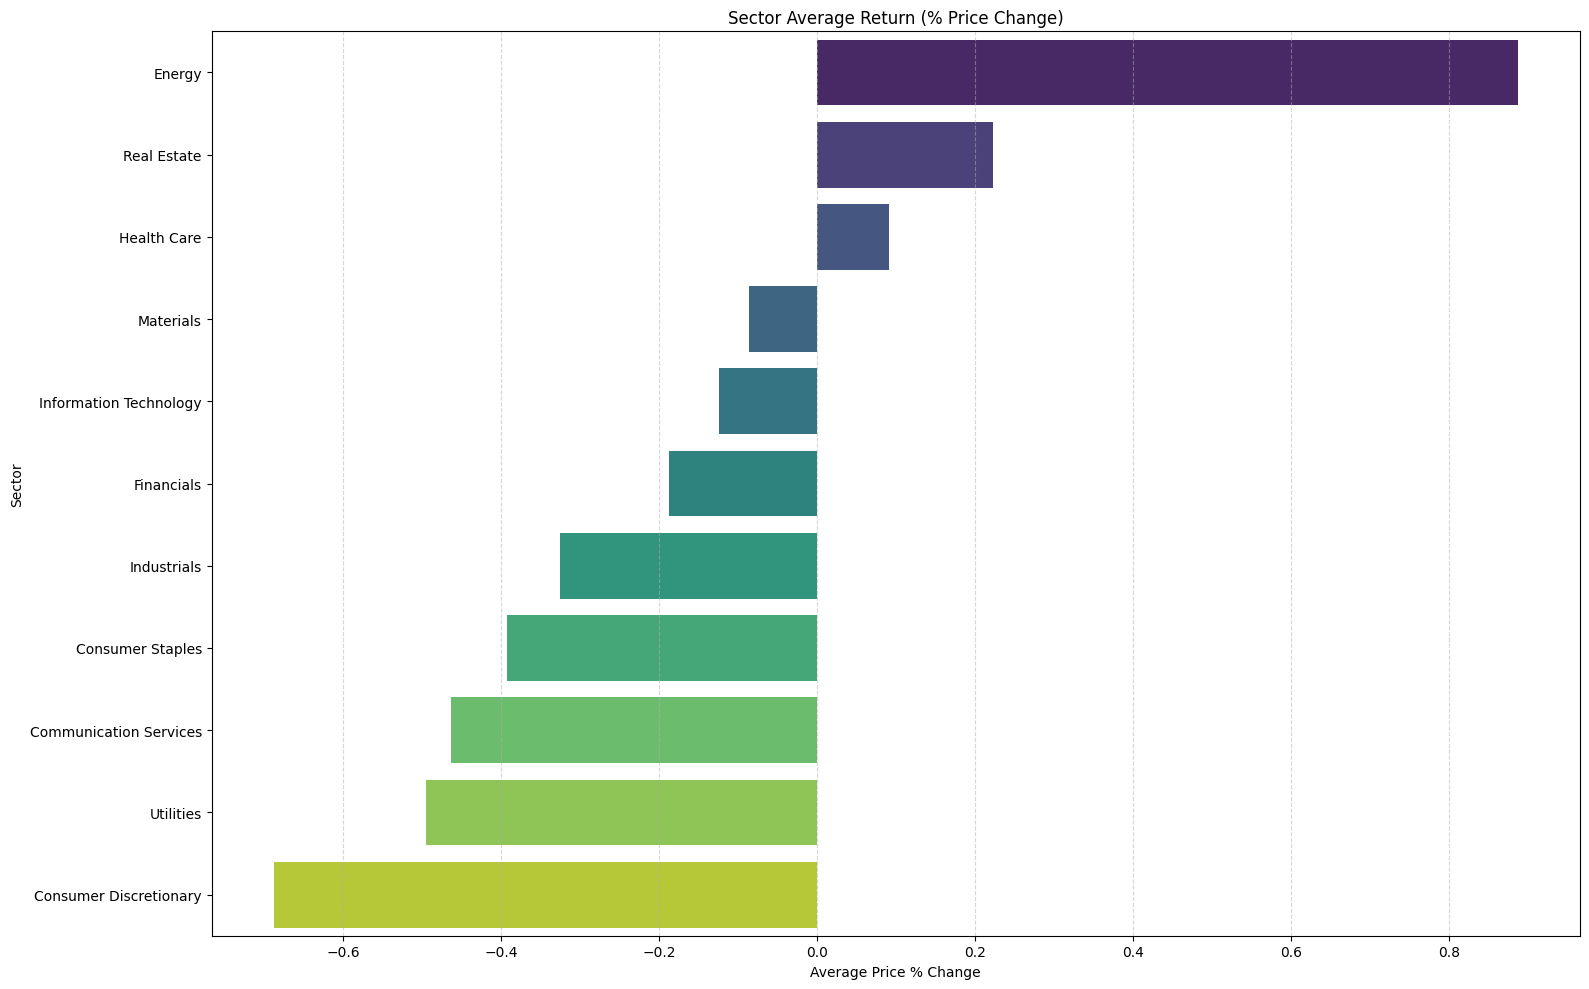

In [35]:
# Display a bar chart for sector average return
plt.figure(figsize = (16, 10))
sns.barplot(x = sector_return.values, y = sector_return.index, palette = "viridis")
plt.title("Sector Average Return (% Price Change)")
plt.xlabel("Average Price % Change")
plt.ylabel("Sector")
plt.grid(True, axis = "x", linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show()

In [36]:
# Find the sector average price movement
sector_movement = sp500_stocks.groupby("Company Sector")["Price Movement"].mean().sort_values(ascending = False)
print("Sector Ranking by Average Price Movement:")
display(sector_movement)

Sector Ranking by Average Price Movement:


Company Sector
Consumer Discretionary    8.422076
Information Technology    5.035718
Health Care               4.755646
Industrials               3.624215
Communication Services    3.474281
Energy                    3.313095
Real Estate               2.662784
Financials                2.203873
Materials                 1.945749
Utilities                 1.616438
Consumer Staples          1.390411
Name: Price Movement, dtype: float64

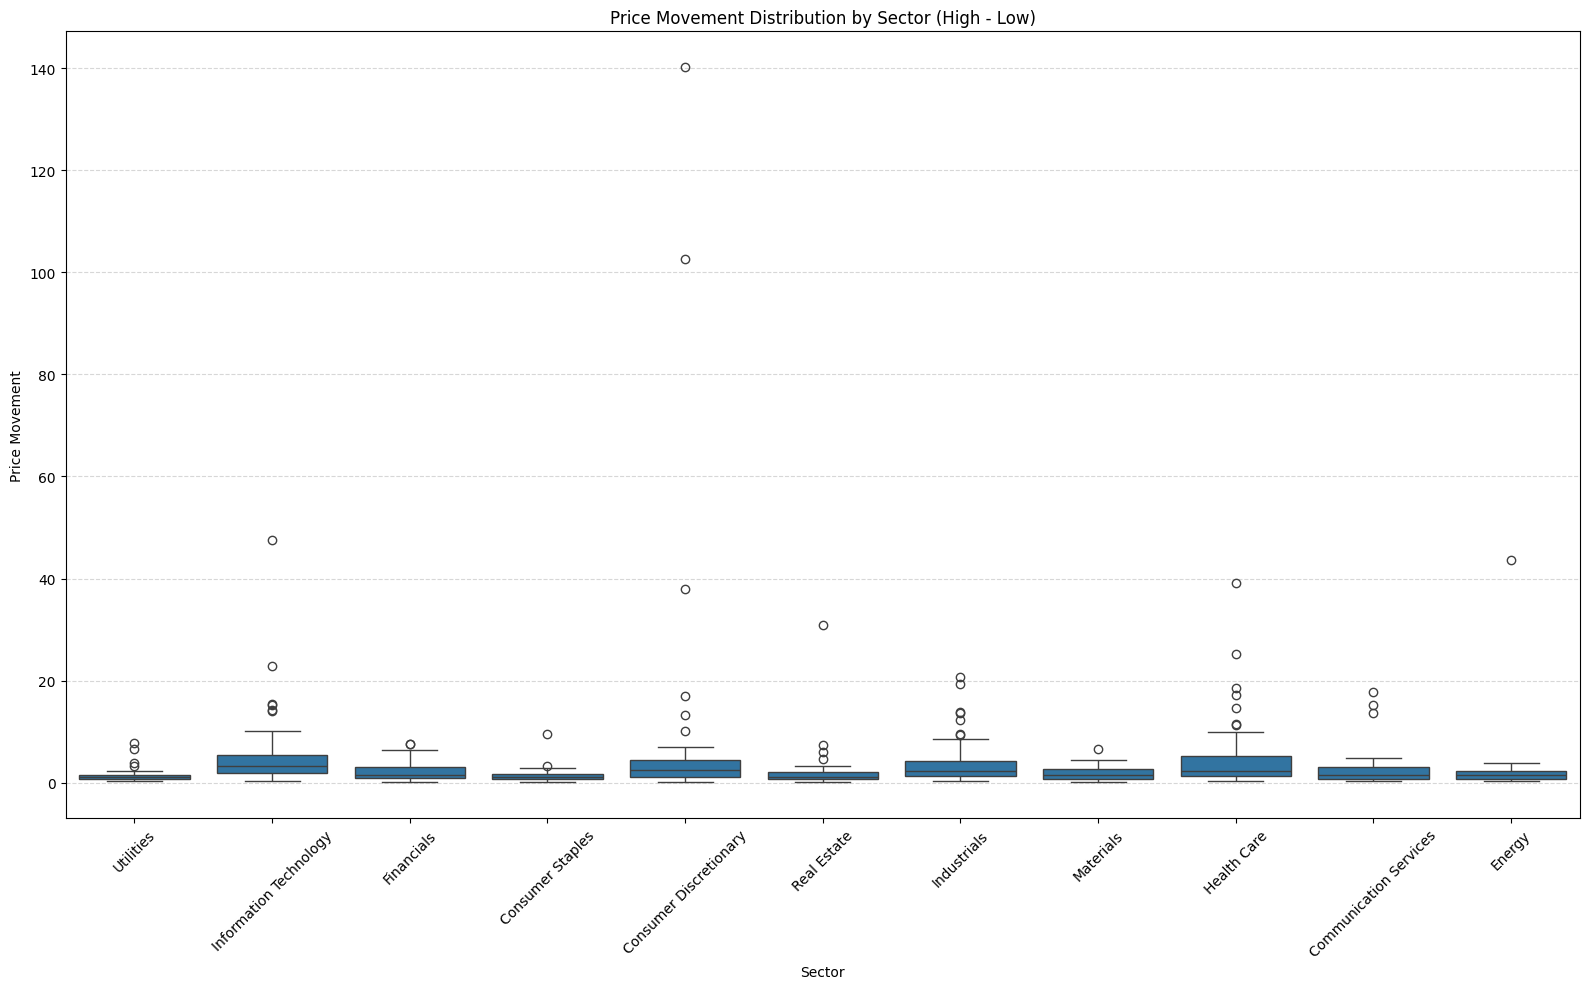

In [37]:
# Display a box plot for price movement by sector
plt.figure(figsize = (16, 10))
sns.boxplot(data = sp500_stocks, x = "Company Sector", y = "Price Movement")
plt.xticks(rotation = 45)
plt.title("Price Movement Distribution by Sector (High - Low)")
plt.xlabel("Sector")
plt.ylabel("Price Movement")
plt.grid(True, axis = "y", linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show()

#### Question 3: Which stocks exhibit the highest/lowest volatility based on daily price range?

In [38]:
# Calculate the price volatility
sp500_stocks["Daily Volatility"] = sp500_stocks["High"] - sp500_stocks["Low"]

In [39]:
# Sort the stocks by highest and lowest volatility
top_volatility = sp500_stocks.sort_values("Daily Volatility", ascending = False).head(10)
low_volatility = sp500_stocks.sort_values("Daily Volatility", ascending = True).head(10)

In [40]:
# Display top 10 most volatile stocks
print("Top 10 Most Volatile Stocks (Today):")
display(display(top_volatility[["Ticker", "Company Name", "Daily Volatility", "High", "Low", "Stock Price"]])
)

Top 10 Most Volatile Stocks (Today):


,Ticker,Company Name,Daily Volatility,High,Low,Stock Price
461,NVR,"NVR, Inc.",140.243652,7299.589844,7159.346191,7168.50
477,BKNG,Booking Holdings Inc. Common Stock,102.534668,5141.109863,5038.575195,5084.07
364,FICO,Fair Isaac Corporation,47.530029,2131.169922,2083.639893,2097.00
73,TPL,Texas Pacific Land Corporation,43.609985,1314.209961,1270.599976,1291.07
500,MCK,McKesson Corporation,39.214905,721.645020,682.430115,694.95
367,AZO,"AutoZone, Inc.",38.010010,3675.000000,3636.989990,3652.87
54,EQIX,"Equinix, Inc.",30.899902,868.270020,837.370117,864.08
484,MTD,"Mettler-Toledo International, Inc.",25.219971,1112.750000,1087.530029,1088.39
110,MPWR,"Monolithic Power Systems, Inc.",22.760010,653.380005,630.619995,636.27
125,TDG,Transdigm Group Inc.,20.674438,1389.304443,1368.630005,1372.14


None

C:\Users\Nitan\AppData\Local\Temp\ipykernel_10000\2111309736.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = top10, x = "Daily Volatility", y = "Ticker", palette = "Reds_r")


<function matplotlib.pyplot.show(close=None, block=None)>

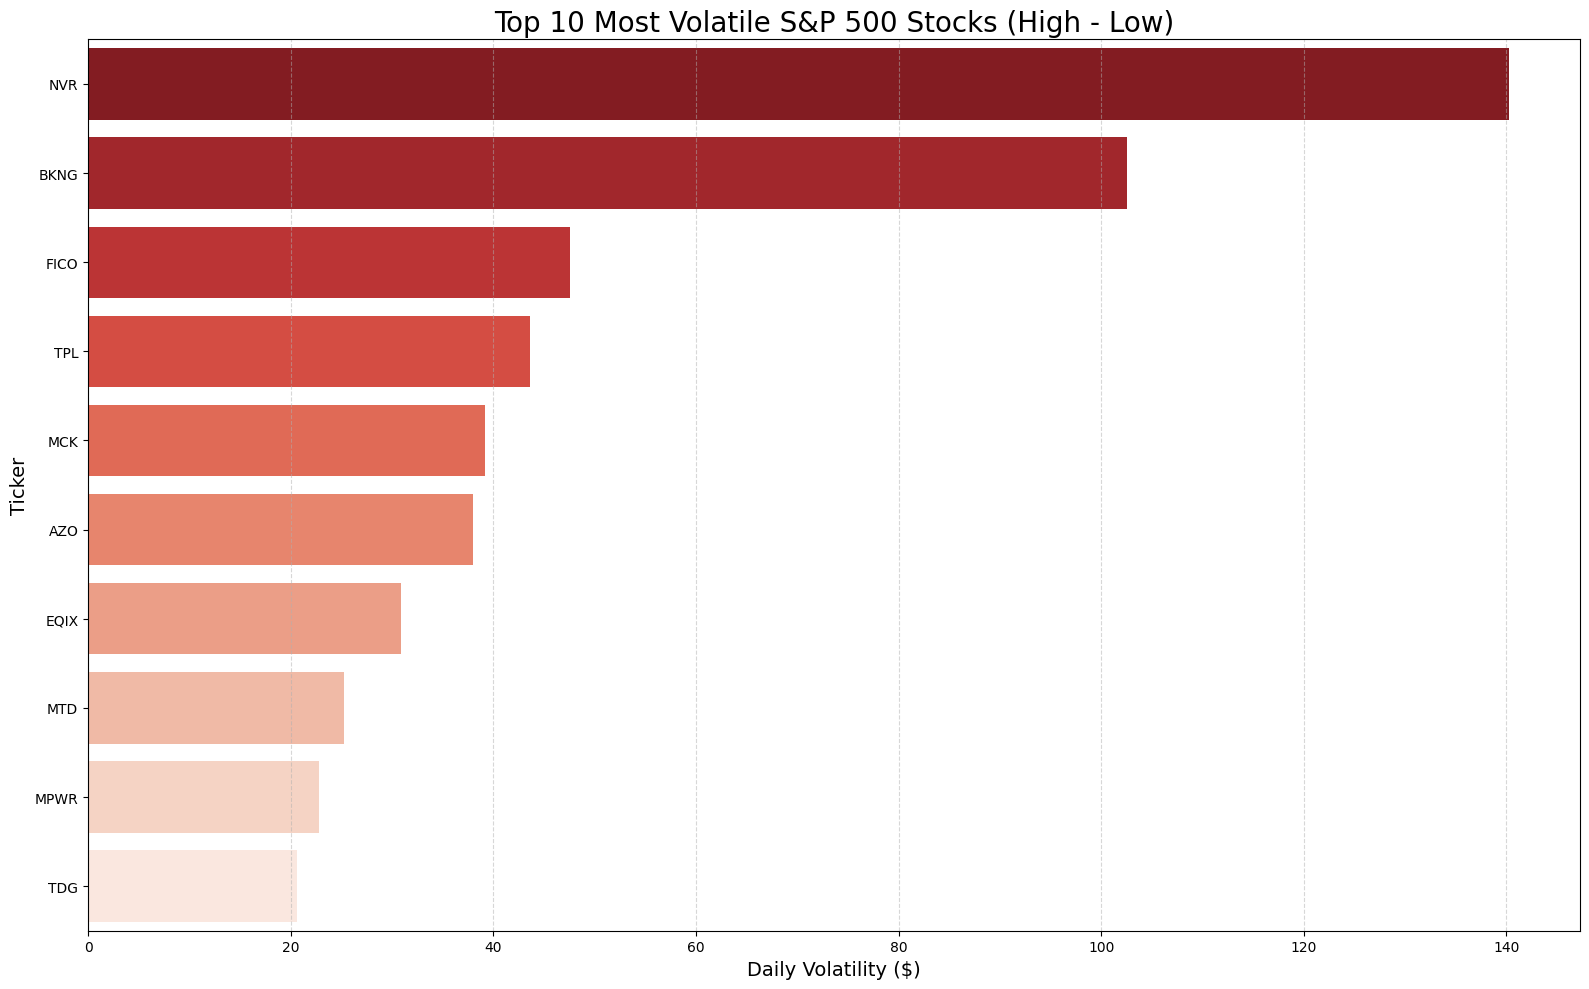

In [41]:
# Display chart for top 10 most volatile stocks
top10 = sp500_stocks.sort_values("Daily Volatility", ascending = False).head(10)

plt.figure(figsize = (16, 10))
sns.barplot(data = top10, x = "Daily Volatility", y = "Ticker", palette = "Reds_r")
plt.title("Top 10 Most Volatile S&P 500 Stocks (High - Low)", fontsize = 20)
plt.xlabel("Daily Volatility ($)", fontsize = 14)
plt.ylabel("Ticker", fontsize = 14)
plt.grid(True, axis = "x", linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show

In [42]:
# Display top 10 least volatile stocks
print("Top 10 Least Volatile Stocks (Today):")
display(low_volatility[["Ticker", "Company Name", "Daily Volatility", "High", "Low", "Stock Price"]])

Top 10 Least Volatile Stocks (Today):


,Ticker,Company Name,Daily Volatility,High,Low,Stock Price
493,WBA,"Walgreens Boots Alliance, Inc.",0.059999,11.200000,11.140000,11.18
341,AMCR,Amcor plc,0.064500,9.179500,9.115000,9.13
501,F,Ford Motor Company,0.130899,10.490000,10.359100,10.39
63,HBAN,Huntington Bancshares Incorporated,0.159901,15.300000,15.140100,15.21
362,K,Kellanova,0.169998,82.699997,82.529999,82.55
6,HST,"Host Hotels & Resorts, Inc.",0.184999,14.900000,14.715000,14.77
53,IVZ,Invesco Ltd,0.184999,14.870000,14.685000,14.70
189,BEN,"Franklin Resources, Inc.",0.210001,21.110001,20.900000,20.93
152,JNPR,"Juniper Networks, Inc.",0.219997,36.424999,36.205002,36.24
308,DOC,"Healthpeak Properties, Inc.",0.236200,17.600000,17.363800,17.45


C:\Users\Nitan\AppData\Local\Temp\ipykernel_10000\2207005313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = bottom10, x = "Daily Volatility", y = "Ticker", palette = "Greens")


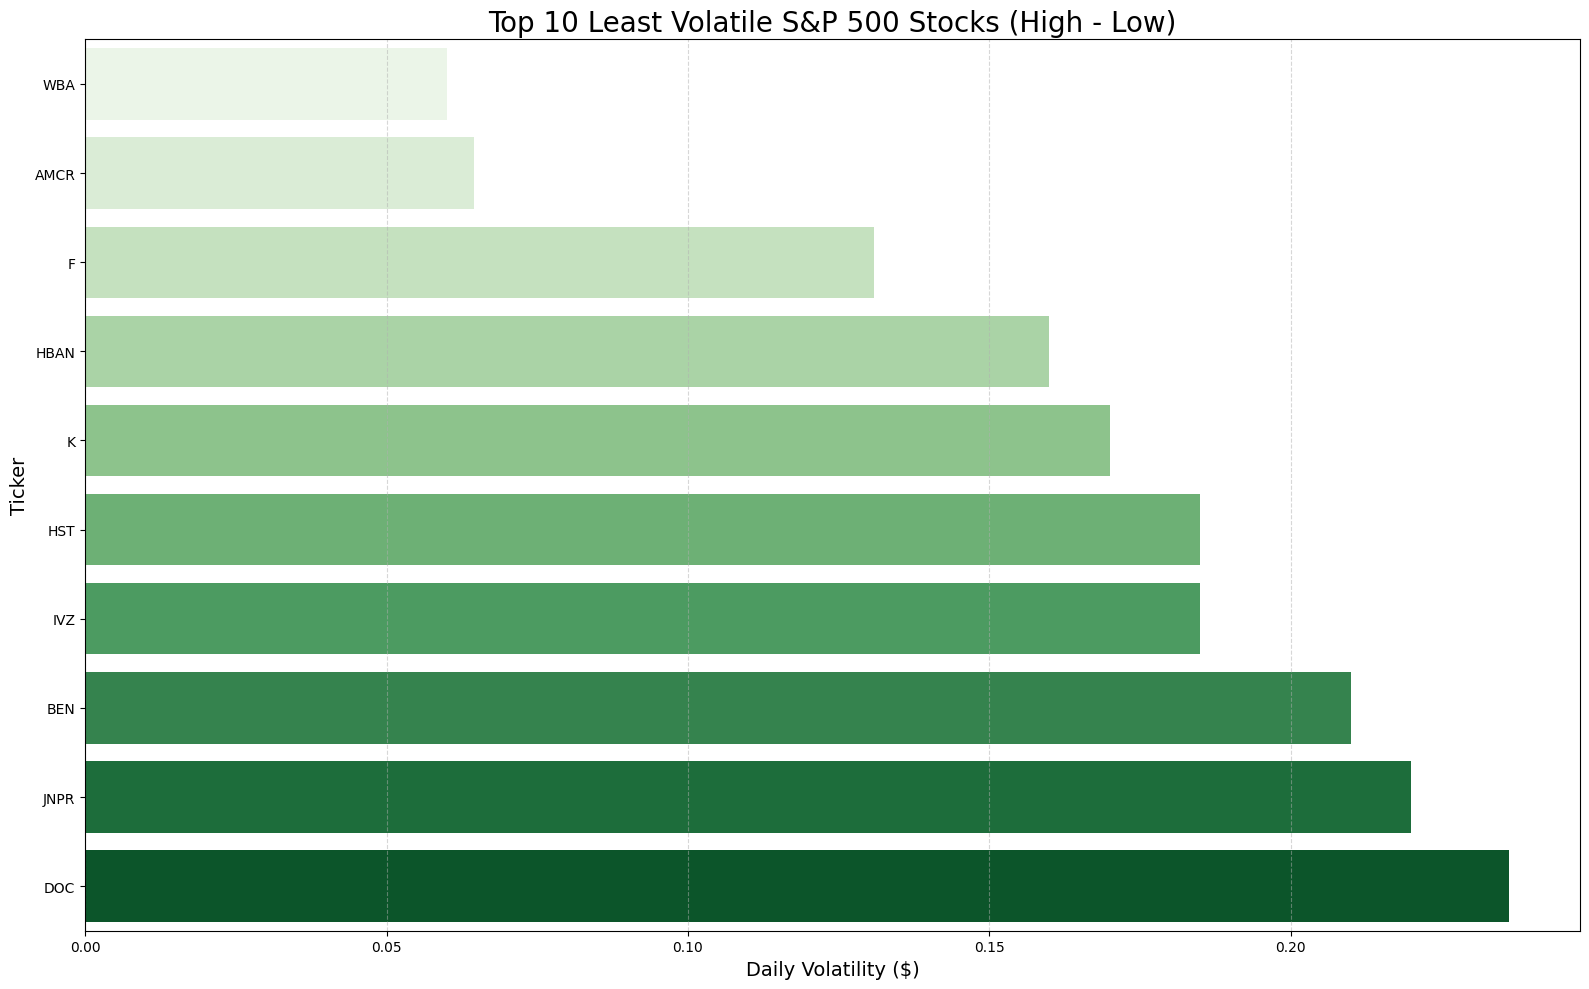

In [43]:
# Display chart for top 10 least volatile stocks
bottom10 = sp500_stocks.sort_values("Daily Volatility", ascending = True).head(10)

plt.figure(figsize = (16, 10))
sns.barplot(data = bottom10, x = "Daily Volatility", y = "Ticker", palette = "Greens")
plt.title("Top 10 Least Volatile S&P 500 Stocks (High - Low)", fontsize = 20)
plt.xlabel("Daily Volatility ($)", fontsize = 14)
plt.ylabel("Ticker", fontsize = 14)
plt.grid(True, axis = "x", linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show()

#### Question 4: Which stocks have unusual trading volume activity today relative to their normal average volume?

In [44]:
# Calculate the 30-Days Average Volume from historical data
avg_volume = yh_stocksector.groupby("Ticker")["Volume"].mean().reset_index()
avg_volume = avg_volume.rename(columns={"Volume": "30-Day Avg Volume"})

In [45]:
# Merge the average volume to the dataframe
sp500_stocks = pd.merge(sp500_stocks, avg_volume, on = "Ticker", how = "left")

In [46]:
# Calculate the Volume Spike Ratio
sp500_stocks["Volume Spike Ratio"] = sp500_stocks["Volume"] / sp500_stocks["30-Day Avg Volume"]

In [47]:
# Identify the top 10 unusal volume stocks
unusual_volume = sp500_stocks.sort_values("Volume Spike Ratio", ascending = False).head(10)

# Display the result
print("Top 10 Stocks with Unusally High Volume Today:")
display(unusual_volume[["Ticker", "Company Name", "Stock Price", "Volume", "30-Day Avg Volume", "Volume Spike Ratio", "Price % Change (Numeric)"]])

Top 10 Stocks with Unusally High Volume Today:


,Ticker,Company Name,Stock Price,Volume,30-Day Avg Volume,Volume Spike Ratio,Price % Change (Numeric)
99,PODD,Insulet Corporation,309.43,2136314.0,7.107554e+05,3.005695,20.40
217,EXPE,"Expedia Group, Inc.",156.24,4293400.0,2.010388e+06,2.135608,-7.54
500,MCK,McKesson Corporation,694.95,1178766.0,8.918461e+05,1.321715,0.68
43,MCHP,Microchip Technology Incorporated,54.15,12595290.0,1.055538e+07,1.193257,10.19
315,MTCH,"Match Group, Inc.",27.25,5437295.0,4.856402e+06,1.119614,-0.82
229,AKAM,"Akamai Technologies, Inc.",78.83,2344508.0,2.236950e+06,1.048082,-7.74
162,FSLR,"First Solar, Inc.",140.25,3052921.0,2.942706e+06,1.037454,4.85
194,TSLA,"Tesla, Inc.",297.31,95632435.0,1.035135e+08,0.923864,4.39
56,ZBH,"Zimmer Biomet Holdings, Inc.",95.80,1675886.0,1.922131e+06,0.871890,0.73
279,SOLV,Solventum Corporation,70.00,896889.0,1.049797e+06,0.854345,5.06


In [48]:
# Do a hypothesis test (Do high volume stocks show higher price movement?)
high_spike = sp500_stocks[sp500_stocks["Volume Spike Ratio"] > 1.5]["Price % Change (Numeric)"]
normal_spike = sp500_stocks[sp500_stocks["Volume Spike Ratio"] <= 1.5]["Price % Change (Numeric)"]

from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(high_spike.dropna(), normal_spike.dropna(), equal_var = False)

In [49]:
# Display the hypothesis test result
print("Hypothesis Test:")
print("Do stocks with high volume spikes have different average price % changes?")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.3f}")

Hypothesis Test:
Do stocks with high volume spikes have different average price % changes?
T-statistic: 0.475
P-value: 0.717


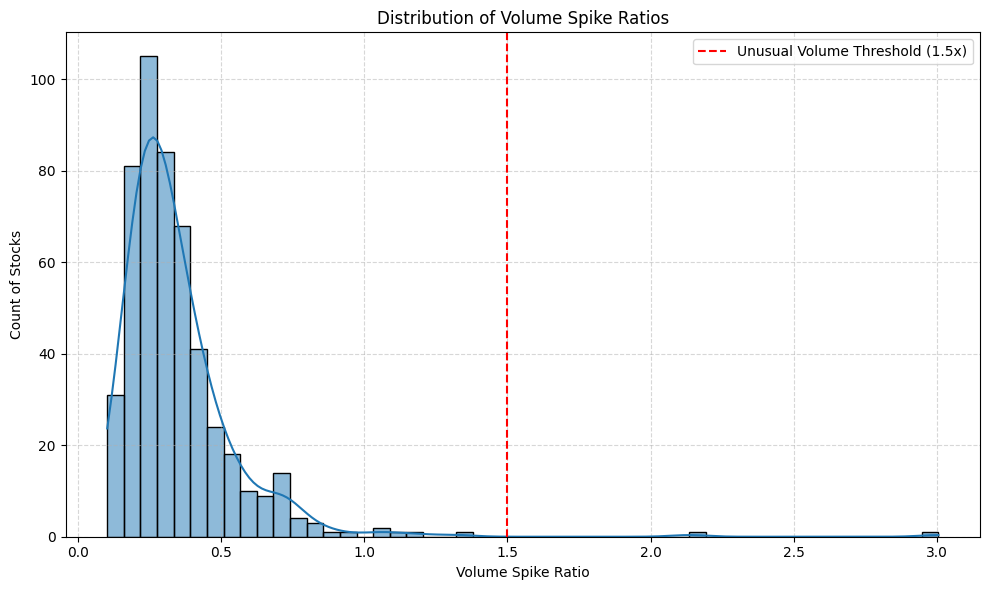

In [50]:
# Display a histogram
plt.figure(figsize = (10, 6))
sns.histplot(sp500_stocks["Volume Spike Ratio"], bins = 50, kde = True)
plt.axvline(1.5, color = 'red', linestyle = '--', label = 'Unusual Volume Threshold (1.5x)')
plt.title("Distribution of Volume Spike Ratios")
plt.xlabel("Volume Spike Ratio")
plt.ylabel("Count of Stocks")
plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()

### Time Series Analysis

#### Short-term predictions for the 3 top-volume S&P 500 stocks using ARIMA

In [51]:
# Import package
from statsmodels.tsa.arima.model import ARIMA 

In [52]:
# Identify top high-volume stocks 
topvol_stocks = sp500_latestprice.sort_values('Volume', ascending = False)['Ticker'].dropna().unique()[:3].tolist()

display(topvol_stocks)

['TSLA', 'NVDA', 'PLTR']


--- Forecasting for TSLA ---


C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_m

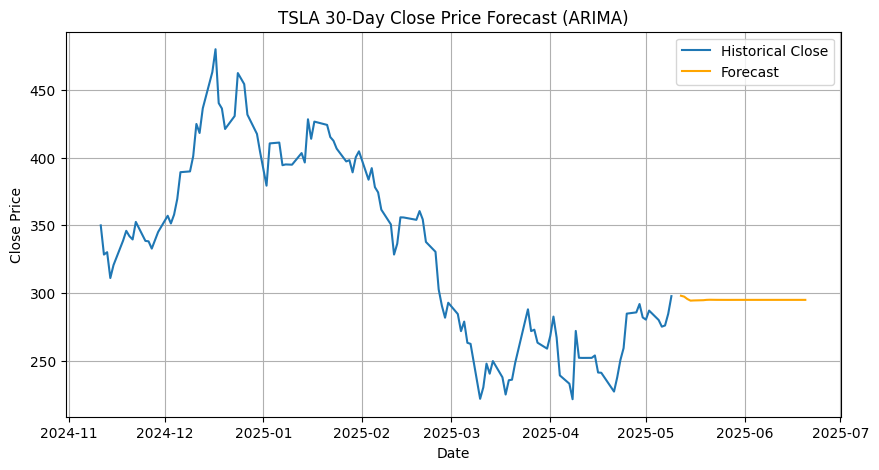


--- Forecasting for NVDA ---


C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_m

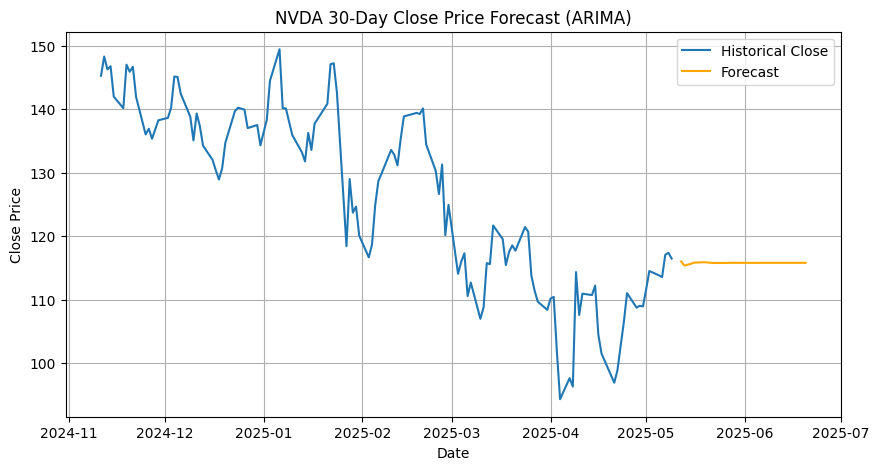


--- Forecasting for PLTR ---


C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_m

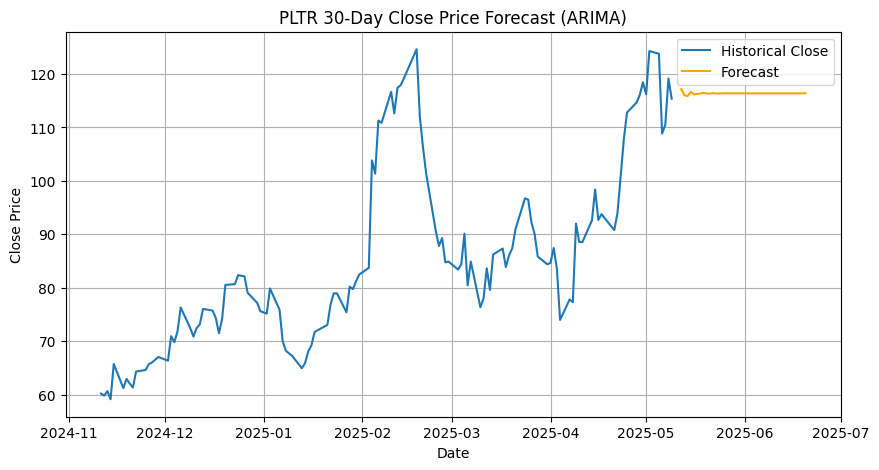

In [53]:
# Forecast for each of the top 3 stocks using ARIMA
forecast_days = 30

for ticker in topvol_stocks:
    print(f"\n--- Forecasting for {ticker} ---")
    try:
        # Filter historical close prices for the ticker
        ticker_data = yfinance_ohlc_data[yfinance_ohlc_data['Ticker'] == ticker][['Date', 'Close']].dropna()
        ticker_data = ticker_data.sort_values('Date').set_index('Date')

        if ticker_data['Close'].isnull().all() or len(ticker_data) < 30:
            print(f"Skipping {ticker} due to insufficient or missing data.")
            continue

        # Fit ARIMA model
        model = ARIMA(ticker_data['Close'], order = (5, 1, 0))
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps = forecast_days)

        # Plot
        plt.figure(figsize = (10, 5))
        plt.plot(ticker_data['Close'], label='Historical Close')
        future_dates = pd.date_range(ticker_data.index[-1], periods = forecast_days + 1, freq = 'B')[1:]
        plt.plot(future_dates, forecast, label = 'Forecast', color = 'orange')
        plt.title(f'{ticker} 30-Day Close Price Forecast (ARIMA)')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

### Resave the dataframe with all columns into csv file

In [54]:
display(sp500_stocks.head(5))

,Ticker,Company Name,Company Sector,Date,Stock Price,Open,High,Low,Close,Price % Change (Numeric),Volume,Signal,Predicted Signal,Price Movement,Daily Volatility,30-Day Avg Volume,Volume Spike Ratio
0,ATO,Atmos Energy Corporation,Utilities,2025-05-09,158.93,161.479996,161.645004,157.835007,159.460007,-1.44,355675.0,Hold,Hold,3.809998,3.809998,9.695144e+05,0.366859
1,NVDA,NVIDIA Corporation,Information Technology,2025-05-09,116.36,117.345001,118.230003,115.209999,116.451103,-0.86,89790548.0,Hold,Hold,3.020004,3.020004,2.626858e+08,0.341817
2,RJF,"Raymond James Financial, Inc.",Financials,2025-05-09,144.97,146.240005,146.759995,144.160004,145.217499,-0.39,408850.0,Hold,Hold,2.599991,2.599991,1.387896e+06,0.294583
3,TAP,Molson Coors Beverage Company,Consumer Staples,2025-05-09,54.61,54.000000,55.424999,54.060001,54.759998,0.64,1499392.0,Hold,Hold,1.364998,1.364998,2.156341e+06,0.695341
4,TPR,"Tapestry, Inc.",Consumer Discretionary,2025-05-09,77.75,78.370003,79.029999,77.309998,77.860001,0.26,2163806.0,Hold,Hold,1.720001,1.720001,5.546427e+06,0.390126


In [55]:
# Reordered the columns
sp500_stocks = sp500_stocks[[
    "Ticker",
    "Company Name",
    "Company Sector",
    "Date",
    "Stock Price",
    "Open",
    "High",
    "Low",
    "Close",
    "Price % Change (Numeric)",
    "Price Movement",
    "Daily Volatility",
    "Volume",
    "30-Day Avg Volume",
    "Volume Spike Ratio",
    "Signal",
    "Predicted Signal"
]]

display(sp500_stocks.head(5))

,Ticker,Company Name,Company Sector,Date,Stock Price,Open,High,Low,Close,Price % Change (Numeric),Price Movement,Daily Volatility,Volume,30-Day Avg Volume,Volume Spike Ratio,Signal,Predicted Signal
0,ATO,Atmos Energy Corporation,Utilities,2025-05-09,158.93,161.479996,161.645004,157.835007,159.460007,-1.44,3.809998,3.809998,355675.0,9.695144e+05,0.366859,Hold,Hold
1,NVDA,NVIDIA Corporation,Information Technology,2025-05-09,116.36,117.345001,118.230003,115.209999,116.451103,-0.86,3.020004,3.020004,89790548.0,2.626858e+08,0.341817,Hold,Hold
2,RJF,"Raymond James Financial, Inc.",Financials,2025-05-09,144.97,146.240005,146.759995,144.160004,145.217499,-0.39,2.599991,2.599991,408850.0,1.387896e+06,0.294583,Hold,Hold
3,TAP,Molson Coors Beverage Company,Consumer Staples,2025-05-09,54.61,54.000000,55.424999,54.060001,54.759998,0.64,1.364998,1.364998,1499392.0,2.156341e+06,0.695341,Hold,Hold
4,TPR,"Tapestry, Inc.",Consumer Discretionary,2025-05-09,77.75,78.370003,79.029999,77.309998,77.860001,0.26,1.720001,1.720001,2163806.0,5.546427e+06,0.390126,Hold,Hold


In [56]:
# Resave the final dataframe into csv
sp500_stocks.to_csv("sp500_stocks.csv", index = False)